In [1]:
#Install Dependencies

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define transformer
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

/home/jtlumpk/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
#DNN1
class DNN1(nn.Module):
    def __init__(self):
        super(DNN1, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(784, 64),  # Change input size to 784
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),  # Change output size to 10 (one for each class)
        )

    def forward(self, x):
        return self.fc(x)

In [4]:
# Define training loop
epochs = 10
learning_rate = 0.01
model = DNN1().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

batch_sizes = [16, 32, 64, 128, 256]
loss_list = []
accuracy_list = []
sensitivity_list = []
train_loss_list = []
train_accuracy_list = []

for batch_size in batch_sizes:
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    
    print(f"Batch size: {batch_size}")

    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}")
        train_loss = 0
        train_accuracy = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images.view(-1, 784))
            loss = nn.CrossEntropyLoss()(outputs, labels)

            #print(f"Loss (train): {loss.item()}")

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_accuracy += (predicted == labels).sum().item()

        train_loss /= len(trainloader.dataset)
        train_accuracy = train_accuracy / len(trainloader.dataset)

        print(f"Train Loss: {train_loss}")
        print(f"Train Accuracy: {train_accuracy}")
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        with torch.no_grad():
            test_loss = 0
            accuracy = 0

            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images.view(-1, 784))
                test_loss += nn.CrossEntropyLoss(reduction='sum')(outputs, labels).item()

                _, predicted = torch.max(outputs, 1)
                accuracy += (predicted == labels).sum().item()

            test_loss /= len(testloader.dataset)
            accuracy = accuracy / len(testloader.dataset)

            print(f"Test Loss: {test_loss}")
            print(f"Test Accuracy: {accuracy}")

            loss_list.append(test_loss)
            accuracy_list.append(accuracy)
    
    def get_loss_sensitivity(model, input_batch, target_batch):
        model.zero_grad()
        output = model(input_batch.view(-1, 784))
        loss = nn.CrossEntropyLoss()(output, target_batch)
        loss.backward()
        gradients = torch.cat([p.grad.view(-1) for p in model.parameters()])
        sensitivity = torch.norm(gradients, p='fro')
        return sensitivity
    
    # Sensitivity
    sensitivity = get_loss_sensitivity(model, images, labels)
    sensitivity_list.append(sensitivity)

Batch size: 16
Epoch: 1
Train Loss: 0.03355795098049566
Train Accuracy: 0.8465
Test Loss: 0.3082605923652649
Test Accuracy: 0.9066
Epoch: 2
Train Loss: 0.015811688105451565
Train Accuracy: 0.9247166666666666
Test Loss: 0.20596975014209748
Test Accuracy: 0.936
Epoch: 3
Train Loss: 0.01180571499262005
Train Accuracy: 0.9427666666666666
Test Loss: 0.17045520258545876
Test Accuracy: 0.9475
Epoch: 4
Train Loss: 0.009625121911102905
Train Accuracy: 0.95415
Test Loss: 0.14951489536464213
Test Accuracy: 0.9534
Epoch: 5
Train Loss: 0.008178063432057387
Train Accuracy: 0.9606666666666667
Test Loss: 0.12907462259531022
Test Accuracy: 0.9598
Epoch: 6
Train Loss: 0.00713622261985438
Train Accuracy: 0.9655
Test Loss: 0.11271849874854088
Test Accuracy: 0.9651
Epoch: 7
Train Loss: 0.006409917464080111
Train Accuracy: 0.9684
Test Loss: 0.12053536723852158
Test Accuracy: 0.9622
Epoch: 8
Train Loss: 0.00581224908696313
Train Accuracy: 0.9720333333333333
Test Loss: 0.13677060270607472
Test Accuracy: 0.957

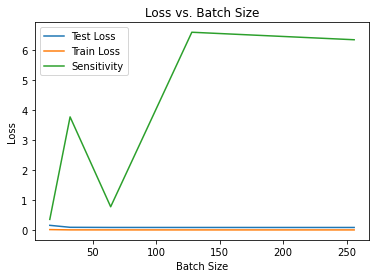

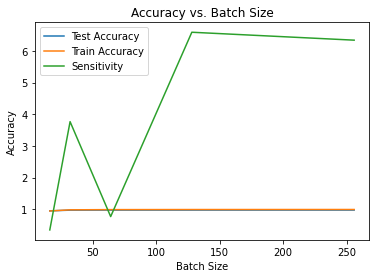

In [5]:
mean_loss_list = [sum(loss_list[i:i+10])/10 for i in range(0, len(loss_list), 10)]
mean_accuracy_list = [sum(accuracy_list[i:i+10])/10 for i in range(0, len(accuracy_list), 10)]
mean_train_loss_list = [sum(train_loss_list[i:i+10])/10 for i in range(0, len(train_loss_list), 10)]
mean_train_accuracy_list = [sum(train_accuracy_list[i:i+10])/10 for i in range(0, len(train_accuracy_list), 10)]

# Plot loss vs. batch size
plt.plot(batch_sizes, mean_loss_list, label='Test Loss')
plt.plot(batch_sizes, mean_train_loss_list, label='Train Loss')
plt.plot(batch_sizes, sensitivity_list, label='Sensitivity')
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.title('Loss vs. Batch Size')
plt.legend()
plt.show()

# Plot accuracy vs. batch size
plt.plot(batch_sizes, mean_accuracy_list, label='Test Accuracy')
plt.plot(batch_sizes, mean_train_accuracy_list, label='Train Accuracy')
plt.plot(batch_sizes, sensitivity_list, label='Sensitivity')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Batch Size')
plt.legend()
plt.show()